Current protocol will always find the stencil which fits the data best - but necessarily the most stable one. We can try to tackle this problem by employing validation.

In [1]:
# some variables controlling the output
VERBOSE = False
INFERENCE_TIME = True

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from itertools import combinations
import scipy.signal as signal
from scipy.ndimage import gaussian_filter1d
from tqdm.notebook import trange, tqdm
import time

# Automatic Selection of Numerically Most Stable Stencil

The linear advection equation

$\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x}=0$

with initial condition

$u(x,0) = u_0(x)$

has the analytic solution

$u(x,t) = u_0(x-ct)$

See: https://www.tat.physik.uni-tuebingen.de/~kley/exo16/hydro/P1.pdf

In [3]:
def d_u_1(x):
    x = np.mod(x,1)
    a = -(16*(1+4*np.exp(1)+np.exp(2)))/(np.sqrt(np.exp(1))*(1-8*np.exp(1) + np.exp(2)))
    b = (16*(1+8*np.exp(1)+3*np.exp(2)))/(np.sqrt(np.exp(1))*(1-8*np.exp(1) + np.exp(2)))
    c = -(48*np.sqrt(np.exp(1))*(1+np.exp(1)))/(1-8*np.exp(1)+np.exp(2))
    d = (16*(-1+np.exp(1))*np.sqrt(np.exp(1)))/((1-8*np.exp(1) + np.exp(2)))
    return np.exp(x)*(d + 2*c*x + 3*b*x**2 + 4*a*x**3) + np.exp(x)*( d*x + c*x**2 + b*x**3 + a*x**4)
def d_u_2(x):
    x = np.mod(x,1)
    return 4*16*x**3-32*3*x**2+16*2*x
def d_u_3(x, n = 500):
    # Clausen 2
    k = np.linspace(1,n, num=n, dtype=np.int64)
    result = np.zeros(x.shape)
    for i in k:
        result += -i*(2*np.pi)*np.sin(i*x*(2*np.pi))/i**3
    return result

In [4]:
# some initial values, periodic in [0,1]
def f_1(x):
    x = np.mod(x,1)
    a = -(16*(1+4*np.exp(1)+np.exp(2)))/(np.sqrt(np.exp(1))*(1-8*np.exp(1) + np.exp(2)))
    b = (16*(1+8*np.exp(1)+3*np.exp(2)))/(np.sqrt(np.exp(1))*(1-8*np.exp(1) + np.exp(2)))
    c = -(48*np.sqrt(np.exp(1))*(1+np.exp(1)))/(1-8*np.exp(1)+np.exp(2))
    d = (16*(-1+np.exp(1))*np.sqrt(np.exp(1)))/((1-8*np.exp(1) + np.exp(2)))
    return np.exp(x)*(a*(x**4) + b*(x**3) + c*(x**2) + d*x)
    
def f_2(x):
    x = np.mod(x,1)
    return 16*x**4-32*x**3+16*x**2


def clausen3(x, n = 500):
    # Clausen 3
    k = np.linspace(1,n, num=n, dtype=np.int64)
    result = np.zeros(x.shape)
    for i in k:
        result += np.cos(i*x*(2*np.pi))/i**3
    return result

max_clausen3 = clausen3(np.array([0.0]), n=10000)[0]
f_3 = lambda x: clausen3(x)-max_clausen3

Text(0.5, 1.0, 'Initial Values')

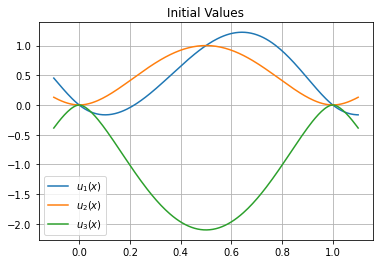

In [5]:
# plot functions under consideration
xs = np.linspace(-0.1, 1.1, num=200)
plt.plot(xs, f_1(xs), label="$u_1(x)$")
plt.plot(xs, f_2(xs), label="$u_2(x)$")
plt.plot(xs, f_3(xs), label="$u_3(x)$")
plt.legend()
plt.grid()
plt.title("Initial Values")

Text(0.5, 1.0, 'Derivatives')

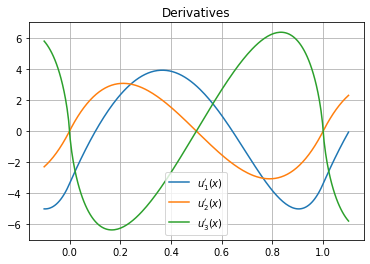

In [6]:
plt.plot(xs, d_u_1(xs), label="$u_1'(x)$")
plt.plot(xs, d_u_2(xs), label="$u_2'(x)$")
plt.plot(xs, d_u_3(xs), label="$u_3'(x)$")
plt.legend()
plt.grid()
plt.title("Derivatives")

In [7]:
rng = np.random.default_rng()

def generate_u_y_xt(u0, c, t_max, delta_t, x_min,x_max, delta_x, noise, sigma=10, du0=None):
    """
    Generate values of u(x,t) and du/dt (x,t) for regression (incl. adding artificial noise and noise filtering)
    u0 : callable, initial state
    c : value of constant
    t_max : maximum t-value on considered interval (min. value is 0)
    delta_t : grid cell size in t
    x_min : min. value of x
    x_max : max. value of x
    delta_x : grid cell size in x
    noise : noise level to add (signal to noise ratio relative to amplitude)
    sigma : sigma for gaussian filter
    du0 : derivative of u0. If not None, will use the analytic equation for the derivative, else will use a forward scheme
    """
    # generate x,t values
    xs = np.arange(x_min, x_max, delta_x)
    ts = np.arange(0, t_max, delta_t)
    
    # matrix to fill in values of u0
    u_xt = np.zeros((ts.shape[0], xs.shape[0]))
    
    # iterate over t indices and fill with analytic solution
    for t_idx in range(0, len(ts)):
        u_xt[t_idx,:] = u0(xs-c*ts[t_idx])
    
    # corresponding values for du/dt (except for last time point, since we don't have a forward value for that)
    y = np.zeros((ts.shape[0]-1, xs.shape[0])) # empty array for storing the results
    for t_idx in range(y.shape[0]): # iterate over t indices of du/dt (does not include the last timepoint for X!)
        if du0 is None: # no analytic derivative provided
            y[t_idx] = (u_xt[t_idx+1]-u_xt[t_idx])/delta_t # forward diff. (other schemes work as well, but yield higher losses)
        else: # use forward diff. --> should be used here, since we use explicit eulerian time stepping
            y[t_idx] = du0(xs-c*ts[t_idx])*(-c)
        
    # if we are supposed to add noise
    if noise != 0.0:
        if VERBOSE:
            print("Adding Noise")
        amplitude_u0 = max(u_xt[0])-min(u_xt[0]) # dynamic range of u0 
        amplitude_d_u0 = max(y[0])-min(y[0]) # dynamic range of du/dt
        
        u_xt += rng.normal(size=u_xt.shape, scale=amplitude_u0*noise) # make u noisy
        y += rng.normal(size=y.shape, scale=amplitude_d_u0*noise) # make y noisy
        u_xt, y = denoise_data(u_xt, y, sigma) # denoise them with a gaussian noise filter
    return u_xt, y, xs, ts # return the (optionally denoised) u, du/dt, and the values for x,t

In [9]:
def denoise_data(u_xt, y_t, sigma=10):
    """
    denoise data with a spatial gaussian filter. This function employs periodic boundary conditions
    u_xt : matrix t_dim x r_dim
    y_t : matrix (t-dim-1) x r_dim
    sigma : sigma for gaussian filter
    """
    for t_ind in range(u_xt.shape[0]): # iterate over all ts in u(x,t)
        u_xt[t_ind,:] = gaussian_filter1d(u_xt[t_ind,:], sigma, mode="wrap") # gaussian filter, 1D, periodic boundaries
    for t_ind in range(y_t.shape[0]): #  same for du/dt
        y_t[t_ind,:] = gaussian_filter1d(y_t[t_ind,:], sigma, mode="wrap")
    return u_xt, y_t

In [10]:
def assemble_matrix(point_list, u_xt, y):
    """
    Assembles regression matrix X for LHS of regression problem
    point_list : tuple of stencil nodes, e.g.(-1,0,1), corresponding to (u_{i-1}, u_i, u_{i+1})
    u_xt : the solution u(x,t)
    y : the corresponding derivative du/dt (x,t)
    """
    x_matrix = np.zeros(((u_xt.shape[0]-1)*u_xt.shape[1], len(point_list))) # no. of datapoints x nodes in set. Here, we don't consider the last time step
    y_matrix = y.ravel() # sorted by time first, then by space
    
    for t_idx in range(0, u_xt.shape[0]-1): # iterate over time (except the last time point)
        for x_idx in range(0, u_xt.shape[1]): # iterate over space
            for p_idx in range(len(point_list)): # collect values for each of the nodes provided in point list
                x_matrix[t_idx*u_xt.shape[1]+x_idx, p_idx] = u_xt[t_idx, np.mod(x_idx+point_list[p_idx], u_xt.shape[1])] # periodic boundaries
    return x_matrix, y_matrix

In [11]:
def propagate(u_xt, stencil, point_list, n_steps, delta_t):
    """
    uses explicit eulerian time stepping to propagate an initial state for n_steps steps
    u_xt : matrix t_ind x r_ind. First element (t_min) is propagated
    stencil : list-like with the stencil coefficients. Same size as point_list
    point_list : tuple of stencil nodes to consider, e.g. (-1,0,1) for the central difference stencil
    n_steps : number of steps to propagate
    delta_t : grid cell size in t
    """
    u_xt_new = u_xt.copy() # copy for new values
    for t_index in range(0, n_steps-1): # propagate for n_steps timesteps from initial values with explicit euler
        u_xt_new[t_index+1,:] = u_xt_new[t_index,:] + delta_t*np.sum(np.array([stencil[p_idx]*np.roll(u_xt_new[t_index,:], -point_list[p_idx]) for p_idx in range(len(point_list))]), axis=0)
    return u_xt_new[:n_steps] # return the n_steps first elements - resulting in n_steps - 1 new values

In [12]:
def loss(u_xt, stencil, point_list, n_steps, delta_t, plot=False):
    """
    Compute loss function (propagation error) and optionally creates a plot of the propagated, final state and the true, final state
    u_xt: matrix t_ind x r_ind
    stencil : the regressed stencil cofficients
    point_list : tuple with the stencil nodes to consider
    n_steps : number of steps to propagate
    """
    u_prop = propagate(u_xt, stencil, point_list, n_steps, delta_t) # propagate
    u_xt_true = u_xt[:n_steps] # corresponding subset
    # make a plot, if required
    if plot:
        plt.plot(u_prop[-1,:], label="Propagtion using "+str(point_list))
        plt.plot(u_xt_true[-1,:], ls="--", label="Analytic Solution")
        plt.legend()
        plt.title("Stability after "+str(n_steps)+" Timesteps")
        plt.xlabel("x")
        plt.ylabel("u(x,t)")
        plt.savefig("plots/stability_stencil_selection.pdf")
        plt.show()
    return np.sum(np.abs(u_prop-u_xt_true)) # accumulated difference

In [13]:
def find_good_stencil(f, c, t_max, delta_t, x_min,x_max, delta_x, possible_points=[-2,-1,0,1,2], possible_sizes = [2,3,4,5], n_steps=80, validation_size=100, noise=0.0, plot=False, sigma=10, return_val=False, dfdt=None):
    """
    Performs an exhaustive search over all possible node sets as stencil support. Returns the set that minimizes the propagation error
    f : callable, initial state
    c : constant in PDE
    t_max : maximal value for t (min. value is 0)
    x_min : minimal value for x
    x_max : maximal value for x
    delta_x : grid cell size in x
    possible_points : array of nodes that are allowed, e.g. (-1,0,1) for the central difference stencil
    possible_sizes : sizes allowed for the final set of variables
    n_steps : size of the validation set
    validation_size : size of the final test set (sorry for the name -.-)
    noise : amount of artificial noise to add
    plot : whether to create a plot of the propagated solution using the final stencil
    sigma : sigma parameter for the gaussian filter
    return_val : whether to return the test set (again, sorry for the name :/ )
    dfdt : the derivative of f, optional --> if not given, will use a forward scheme in time
    """
    # generate data
    u_xt, y_t, xs, ts = generate_u_y_xt(f, c, t_max + validation_size*delta_t, delta_t, x_min,x_max, delta_x, noise, sigma=sigma, du0=dfdt)
    # split the data into validation set, training set and test set (<-- this order applies to the time axis)
    u_xt_train, u_xt_test, u_xt_val = u_xt[n_steps:u_xt.shape[0]-validation_size], u_xt[:n_steps], u_xt[u_xt.shape[0]-validation_size:]
    y_train, y_test, y_val = y_t[n_steps:y_t.shape[0]-validation_size], y_t[:n_steps], y_t[y_t.shape[0]-validation_size:]
    
    # store the current minimal loss on the validation set
    min_loss = np.inf
    # the corresponding variable set
    min_points = None
    # the corresponding regressed stencil
    min_stencil = None
    time1 = time.perf_counter()
    for size in possible_sizes: # iterate over the allowed sizes
        for points in combinations(possible_points, size): # all combinations of specified size without replacement
            x, y = assemble_matrix(points, u_xt_train, y_train) # construct the corresponding matrix
            # perform OLS fit
            lr = LinearRegression(fit_intercept=False)
            lr.fit(x,y)
            # compute the propagation error (on the validation set) corresponding to the regressed coefficients
            l=loss(u_xt_test, lr.coef_, points, n_steps, delta_t)
            if VERBOSE:
                print(points, l, lr.coef_)
            # if loss is better
            # if the stencil contains "overcomplete" variables (that are not contributing significantly by at least 5% of the max. node) we'll skip, if we already found a set of variables
            if l<min_loss and (not np.any(np.abs(lr.coef_)<0.05*np.max(np.abs(lr.coef_)))):#5% is cut-off for un-neccessary coefficients
                min_loss=l
                min_points=points
                min_stencil=lr.coef_
                if VERBOSE:
                    print("Current best loss {}, points {}, stencil {}".format(min_loss, min_points, min_stencil))
    if min_points==None: # it no stencil could be found, select the naive support
        min_points = tuple(possible_points)
        x,y = assemble_matrix(min_points, u_xt_train, y_train)
        lr = LinearRegression(fit_intercept=False)
        lr.fit(x,y)
        min_stencil = lr.coef_
    time2 = time.perf_counter()
    diff = time2-time1
    min_loss = loss(u_xt_val, min_stencil, min_points, u_xt_val.shape[0], delta_t, plot=plot)
    
    
    if return_val:
        return min_loss, min_points, min_stencil, u_xt_val, diff
    else:
        return min_loss, min_points, min_stencil, diff

In [14]:
def comp_tuple(a,b):
    """
    Function to compare two tuples element-wise. Tuples are expected to be sorted in some way, e.g. by the itertools.combinations function
    """
    if len(a)!=len(b): # check for equal length
        return False
    else: # if length is equal, compare elements and return False if they are not the same
        for idx in range(len(a)): # index
            if a[idx]!=b[idx]: # are they equal?
                return False # if not
    return True # if all elements are equal

def tuple_unique(l):
    """
    Compute unique tuples, their respective counts and their respective indices in a list l
    """
    # lists for the result
    uniques = []
    counts = []
    indices = []
    
    # iterate over all elements in list
    for elm_idx, elm in enumerate(l):
        # now, check, whether this element is already contained in unique
        in_unique = False # initial valie
        for u_idx, u in enumerate(uniques): # iterate over the unique values, that were already found
            if comp_tuple(elm, u): # if the respective element of l and uniques are equal
                in_unique = True # return True
                break
        if in_unique: # if element is not the first of its kind 
            counts[u_idx]+=1 # increment the corresponding counter for the unique element
            indices[u_idx].append(elm_idx) # append the current index to the list of indices for the respective unique element
        else: # if the element is unique
            uniques.append(elm)
            counts.append(1) # append a counter for this new, unique element
            indices.append([elm_idx]) # append a corresponding index list
    
    return uniques, counts, indices

In [15]:
def repeated_stencil_finder2(repeats, f, c, t_max, delta_t, x_min,x_max, delta_x, possible_points=[-2,-1,0,1,2], possible_sizes = [2,3,4,5], n_steps=80, validation_size=100, noise=0.0, dfdt=None):
    """
    Performs an analysis with multiple repetitions of the most frequently selected variable set over multiple repetitions
    repeats : no. of repetitions
    all other arguments as in function "find_good_stencil"
    """
    best_support = [] # list with the respectively selected best variable set per repetition
    losses_best_support = [] # corresponding loss
    best_coeffs = [] # corresponding stencil coefficient
    loss_naive = [] # loss using naive, linear regression on the full set of variables
    time_inference = []
    
    # multiple repetitions
    for rep in trange(repeats):
        # find optimal stencil with prescribed procedure
        min_loss, min_points, min_stencil, diff = find_good_stencil(f, c, t_max, delta_t, x_min,x_max, delta_x, possible_points, possible_sizes, n_steps, validation_size, noise, dfdt=dfdt)
        # store results
        best_support.append(min_points)
        best_coeffs.append(min_stencil)
        losses_best_support.append(min_loss)
        time_inference.append(diff)
        # perform linear regression on naive (full) suppoprt
        naive_loss, naive_points, naive_stencil, naive_diff = find_good_stencil(f, c, t_max, delta_t, x_min,x_max, delta_x, possible_points, possible_sizes=[len(possible_points)], n_steps=n_steps, validation_size=validation_size, noise=noise, dfdt=dfdt)
        loss_naive.append(naive_loss) # and store result (we don't care about the coefficients here)
    
    losses_best_support = np.array(losses_best_support)
    
    print("Average loss on best support:\t", np.mean(losses_best_support), "+-", np.std(losses_best_support))
    print("Average time for inference: {}+-{}".format(round(np.mean(time_inference),3), round(np.std(time_inference),3)))
    if noise!=0.0:
        print(best_support)
        uniques, counts, indices = tuple_unique(best_support)
        print("Best supports and their counts:\t", uniques, counts)
        print("Most Frequent Support is",uniques[np.argmax(counts)], "and was selected with a frequency of",round(100*np.max(counts)/np.sum(counts)), "%")
        print("Average loss on most frequently selected support", np.mean(losses_best_support[np.array(indices[np.argmax(counts)])]), "+-", np.std(losses_best_support[np.array(indices[np.argmax(counts)])]))
        most_freq_coeffs = np.array(best_coeffs, dtype="object")[np.array(indices[np.argmax(counts)])]
        most_freq_coeffs = [most_freq_coeffs[i].astype(float) for i in range(most_freq_coeffs.shape[0])]
        most_freq_coeffs = np.vstack(most_freq_coeffs)
        print("Average coeffs. on most frequent support", np.mean(most_freq_coeffs, axis=0), "+-", np.std(most_freq_coeffs, axis=0))
    else:
        print("Selected support\t", best_support[0])
        print("Selected Coefficients\t", best_coeffs[0])
    
    
    print("Loss with naive regression", np.mean(loss_naive), "+-", np.std(loss_naive))
    return best_support, losses_best_support, best_coeffs

## Results for Tab. 1 in Paper

In [16]:
c = 1
delta_x = 0.02
delta_t = 0.02
x_min = 0
x_max = 1
t_max = 4

In [364]:
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(2, f_1, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.0)

  0%|          | 0/2 [00:00<?, ?it/s]

Average loss on best support:	 5.630385139459783e-10 +- 0.0
Selected support	 (-1, 0)
Selected Coefficients	 [ 50. -50.]
Loss with naive regression 1.1153520060240952e-10 +- 0.0


In [44]:
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(2, f_1, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.0)
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(100, f_1, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.025)
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(100, f_1, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.05)
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(100, f_1, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.075)

  0%|          | 0/2 [00:00<?, ?it/s]

Average loss on best support:	 5.630385139459783e-10 +- 0.0
Selected support	 (-1, 0)
Selected Coefficients	 [ 50. -50.]
Loss with naive regression 1.1153520060240952e-10 +- 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Average loss on best support:	 35.70127284993826 +- 9.747324408866064
[(-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, -1, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-2, -1, 0, 2), (-2, 0, 2), (-1, 0), (-2, -1, 0, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 1, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 1, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-

C:\Users\Yannis Schumann\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


  0%|          | 0/100 [00:00<?, ?it/s]

Average loss on best support:	 71.64535379928684 +- 17.96891529496235
[(-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0, 1), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0, 1), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-

C:\Users\Yannis Schumann\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


  0%|          | 0/100 [00:00<?, ?it/s]

Average loss on best support:	 104.80037644601103 +- 27.350655900205503
[(-1, 0, 1), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0, 1), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-2, -1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-2, -1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0,

C:\Users\Yannis Schumann\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [45]:
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(2, f_2, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.0)
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(100, f_2, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.025)
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(100, f_2, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.05)
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(100, f_2, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.075)

  0%|          | 0/2 [00:00<?, ?it/s]

Average loss on best support:	 1.1258040333306241e-10 +- 0.0
Selected support	 (-1, 0)
Selected Coefficients	 [ 50. -50.]
Loss with naive regression 1.212769641656397e-10 +- 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Average loss on best support:	 26.413484231526624 +- 7.817948786668996
[(-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, -1, 0, 2), (-1, 0), (-2, -1, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 

C:\Users\Yannis Schumann\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


  0%|          | 0/100 [00:00<?, ?it/s]

Average loss on best support:	 50.028336794489306 +- 14.19397653528825
[(-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2)

C:\Users\Yannis Schumann\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


  0%|          | 0/100 [00:00<?, ?it/s]

Average loss on best support:	 77.96885093792108 +- 20.92875226908859
[(-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, -1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, -1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2

C:\Users\Yannis Schumann\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [46]:
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(2, f_3, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.0)
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(100, f_3, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.025)
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(100, f_3, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.05)
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(100, f_3, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.075)

  0%|          | 0/2 [00:00<?, ?it/s]

Average loss on best support:	 1.3114961443239093e-09 +- 0.0
Selected support	 (-1, 0)
Selected Coefficients	 [ 50. -50.]
Loss with naive regression 8.088124059391077e-10 +- 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Average loss on best support:	 53.18097385355944 +- 17.86129856785679
[(-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, -1, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, -1, 0, 2), (-1, 0), (-2, -1, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, -1, 0, 1), (-2, -1, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, -1, 0, 2), (-2, -1, 0, 1), (-2, -1, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, -1, 0, 2), (-2, 0, 2), (-1, 0), (-2, -1, 0, 1), (-1, 0), (-2, -1, 0, 2), (-1, 0), (-2, 0, 2), (-2, -1, 0, 1), (-2, -1, 0, 2), (-1, 0), (-2, -1, 0, 1), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, -1, 0, 2), (-1, 0), (-2, -1, 0, 2), (-2, -1, 0, 1), (-1, 0), (-2, 0, 2), (-1, 0), (-2, -1, 0, 2), (-1, 0), (-2, -1, 0, 1), (

  0%|          | 0/100 [00:00<?, ?it/s]

Average loss on best support:	 104.28316656900638 +- 31.38348989458533
[(-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, -1, 0, 1, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, -1, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2),

C:\Users\Yannis Schumann\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


  0%|          | 0/100 [00:00<?, ?it/s]

Average loss on best support:	 164.10320239655954 +- 50.703327381156065
[(-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, -1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-

C:\Users\Yannis Schumann\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


## Reviewers Question on higher-order schemes

In [17]:
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(1, f_1, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.0)
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(1, f_2, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.0)
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(1, f_3, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.0)

  0%|          | 0/1 [00:00<?, ?it/s]

Average loss on best support:	 5.630385139459783e-10 +- 0.0
Average time for inference: 1.159+-0.0
Selected support	 (-1, 0)
Selected Coefficients	 [ 50. -50.]
Loss with naive regression 1.1153520060240952e-10 +- 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

Average loss on best support:	 1.1258040333306241e-10 +- 0.0
Average time for inference: 1.076+-0.0
Selected support	 (-1, 0)
Selected Coefficients	 [ 50. -50.]
Loss with naive regression 1.212769641656397e-10 +- 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

Average loss on best support:	 1.3114961443239093e-09 +- 0.0
Average time for inference: 1.099+-0.0
Selected support	 (-1, 0)
Selected Coefficients	 [ 50. -50.]
Loss with naive regression 8.088124059391077e-10 +- 0.0


In [30]:
# using the new parameters
repeated_stencil_finder2(1, f_1, c, t_max/2, delta_t/2, x_min, x_max, delta_x, noise=0.01, )

  0%|          | 0/1 [00:00<?, ?it/s]

Average loss on best support:	 23.479402698367117 +- 0.0
Average time for inference: 1.976+-0.0
[(-2, 0)]
Best supports and their counts:	 [(-2, 0)] [1]
Most Frequent Support is (-2, 0) and was selected with a frequency of 100 %
Average loss on most frequently selected support 23.479402698367117 +- 0.0
Average coeffs. on most frequent support [ 49.99056443 -49.99134858] +- [0. 0.]
Loss with naive regression 1.1942456877046655e+170 +- 0.0


([(-2, 0)], array([23.4794027]), [array([ 49.99056443, -49.99134858])])

In [34]:
# using the new parameters
repeated_stencil_finder2(100, f_1, c, t_max, delta_t, x_min, x_max, delta_x*2, noise=0.01)

  0%|          | 0/100 [00:00<?, ?it/s]

Average loss on best support:	 8.813020370919643 +- 3.770710177428961
Average time for inference: 0.591+-0.066
[(-2, -1, 0), (-2, -1, 0), (-2, -1, 0), (-2, -1, 0), (-2, -1, 0), (-2, -1, 0, 2), (-2, -1, 0), (-2, -1, 0, 1, 2), (-2, 0, 2), (-2, -1, 0), (-2, -1, 0, 1, 2), (-2, -1, 0), (-2, -1, 0), (-2, -1, 1, 2), (-2, -1, 0, 1, 2), (-2, -1, 1, 2), (-2, -1, 0, 1, 2), (-2, -1, 0), (-2, -1, 0), (-2, 0, 2), (-1, 0, 1), (-2, -1, 0), (-2, 0, 2), (-2, -1, 0, 1, 2), (-1, 0, 2), (-2, -1, 0), (-2, -1, 0, 1, 2), (-2, -1, 0), (-2, 0, 2), (-1, 0, 1, 2), (-1, 0), (-1, 0, 1, 2), (-2, -1, 0, 1, 2), (-2, -1, 0), (-2, -1, 0, 1, 2), (-2, -1, 0), (-1, 0, 1, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0, 1), (-2, -1, 0, 1, 2), (-2, 0, 2), (-2, 0, 2), (-2, -1, 0), (-2, -1, 0), (-2, 0, 2), (-2, -1, 0, 1, 2), (-1, 0, 1, 2), (-2, -1, 0, 1, 2), (-2, 0, 2), (-2, 0, 2), (-2, -1, 0), (-2, -1, 0), (-1, 0, 1), (-2, 0, 2), (-2, 0, 2), (-1, 0, 1), (-1, 0, 1), (-2, -1, 0), (-2, 0, 2), (-1, 0, 1, 2), (-2, -1, 0), (-2, -1, 0), (-2, -1,

([(-2, -1, 0),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, -1, 0, 2),
  (-2, -1, 0),
  (-2, -1, 0, 1, 2),
  (-2, 0, 2),
  (-2, -1, 0),
  (-2, -1, 0, 1, 2),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, -1, 1, 2),
  (-2, -1, 0, 1, 2),
  (-2, -1, 1, 2),
  (-2, -1, 0, 1, 2),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, 0, 2),
  (-1, 0, 1),
  (-2, -1, 0),
  (-2, 0, 2),
  (-2, -1, 0, 1, 2),
  (-1, 0, 2),
  (-2, -1, 0),
  (-2, -1, 0, 1, 2),
  (-2, -1, 0),
  (-2, 0, 2),
  (-1, 0, 1, 2),
  (-1, 0),
  (-1, 0, 1, 2),
  (-2, -1, 0, 1, 2),
  (-2, -1, 0),
  (-2, -1, 0, 1, 2),
  (-2, -1, 0),
  (-1, 0, 1, 2),
  (-2, 0, 2),
  (-2, 0, 2),
  (-1, 0, 1),
  (-2, -1, 0, 1, 2),
  (-2, 0, 2),
  (-2, 0, 2),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, 0, 2),
  (-2, -1, 0, 1, 2),
  (-1, 0, 1, 2),
  (-2, -1, 0, 1, 2),
  (-2, 0, 2),
  (-2, 0, 2),
  (-2, -1, 0),
  (-2, -1, 0),
  (-1, 0, 1),
  (-2, 0, 2),
  (-2, 0, 2),
  (-1, 0, 1),
  (-1, 0, 1),
  (-2, -1, 0),
  (-2, 0, 2),
  (-1, 0, 1, 2),
  (-2, -1, 0),
  (-2, -1

In [35]:
# using the new parameters
repeated_stencil_finder2(100, f_2, c, t_max, delta_t, x_min, x_max, delta_x*2, noise=0.01)

  0%|          | 0/100 [00:00<?, ?it/s]

Average loss on best support:	 6.209501903581679 +- 2.8219710664219058
Average time for inference: 0.59+-0.051
[(-2, -1, 0), (-2, -1, 0, 2), (-2, -1, 0), (-2, -1, 0), (-2, -1, 0, 2), (-1, 0, 1, 2), (-2, -1, 0, 2), (-2, 0, 2), (-2, -1, 0), (-2, -1, 0), (-2, 0, 2), (-2, -1, 0, 1, 2), (-1, 0, 1, 2), (-2, -1, 0, 2), (-1, 0, 1, 2), (-2, -1, 0), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0, 1, 2), (-1, 0, 1), (-2, -1, 0), (-2, -1, 0), (-2, -1, 0), (-2, -1, 0), (-2, -1, 0), (-2, -1, 0, 1, 2), (-2, -1, 0, 1, 2), (-2, 0, 2), (-2, 0, 2), (-2, -1, 0, 2), (-2, 0, 2), (-2, -1, 0, 1, 2), (-1, 0, 1, 2), (-2, 0, 2), (-2, 0, 2), (-2, -1, 0, 1, 2), (-2, -1, 0, 1, 2), (-2, -1, 0, 1, 2), (-1, 0, 1), (-2, -1, 0), (-2, -1, 0, 1, 2), (-2, -1, 0), (-2, -1, 0), (-2, -1, 0, 1, 2), (-2, -1, 0, 1, 2), (-2, -1, 0, 2), (-2, -1, 0, 1, 2), (-2, -1, 0), (-1, 0, 2), (-2, -1, 0, 1, 2), (-2, -1, 0), (-2, -1, 0, 1, 2), (-2, -1, 0, 1, 2), (-1, 0, 1), (-2, -1, 0), (-2, -1, 0), (-2, -1, 0), (-1, 0, 2), (-1, 0, 1, 2

([(-2, -1, 0),
  (-2, -1, 0, 2),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, -1, 0, 2),
  (-1, 0, 1, 2),
  (-2, -1, 0, 2),
  (-2, 0, 2),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, 0, 2),
  (-2, -1, 0, 1, 2),
  (-1, 0, 1, 2),
  (-2, -1, 0, 2),
  (-1, 0, 1, 2),
  (-2, -1, 0),
  (-2, 0, 2),
  (-2, 0, 2),
  (-2, 0, 2),
  (-2, 0, 2),
  (-1, 0, 1, 2),
  (-1, 0, 1),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, -1, 0, 1, 2),
  (-2, -1, 0, 1, 2),
  (-2, 0, 2),
  (-2, 0, 2),
  (-2, -1, 0, 2),
  (-2, 0, 2),
  (-2, -1, 0, 1, 2),
  (-1, 0, 1, 2),
  (-2, 0, 2),
  (-2, 0, 2),
  (-2, -1, 0, 1, 2),
  (-2, -1, 0, 1, 2),
  (-2, -1, 0, 1, 2),
  (-1, 0, 1),
  (-2, -1, 0),
  (-2, -1, 0, 1, 2),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, -1, 0, 1, 2),
  (-2, -1, 0, 1, 2),
  (-2, -1, 0, 2),
  (-2, -1, 0, 1, 2),
  (-2, -1, 0),
  (-1, 0, 2),
  (-2, -1, 0, 1, 2),
  (-2, -1, 0),
  (-2, -1, 0, 1, 2),
  (-2, -1, 0, 1, 2),
  (-1, 0, 1),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, -1, 0),
  (-1, 0, 2),
  (-

In [36]:
# using the new parameters
repeated_stencil_finder2(100, f_3, c, t_max, delta_t, x_min, x_max, delta_x*2, noise=0.01)

  0%|          | 0/100 [00:00<?, ?it/s]

Average loss on best support:	 12.596148789390774 +- 5.579064345560417
Average time for inference: 0.641+-0.119
[(-1, 0, 1), (-2, -1, 0), (-2, 0, 2), (-2, 0, 2), (-2, -1, 0), (-2, -1, 0), (-2, -1, 0), (-2, 0, 2), (-2, 0, 2), (-2, -1, 0, 1), (-2, -1, 0), (-2, -1, 0), (-2, -1, 0, 1), (-2, -1, 0, 1), (-2, -1, 0), (-2, -1, 0), (-1, 0, 1, 2), (-2, -1, 2), (-2, -1, 0, 1), (-1, 0, 1, 2), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-2, -1, 0), (-2, 0, 2), (-2, -1, 0, 1), (-2, -1, 0), (-2, 0, 2), (-2, -1, 0), (-2, -1, 0), (-2, -1, 0, 2), (-2, 0, 2), (-1, 0, 1), (-2, 0, 2), (-2, -1, 0), (-2, 0, 2), (-1, 0, 1, 2), (-1, 0, 1), (-1, 0, 1), (-1, 0, 1), (-2, -1, 0), (-2, 0, 2), (-2, -1, 0), (-2, 0, 2), (-1, 0, 1, 2), (-2, 0, 2), (-1, 0, 1, 2), (-2, 0, 2), (-2, -1, 0), (-2, -1, 0), (-2, 0, 2), (-2, -1, 0), (-1, 0, 1), (-2, -1, 0), (-2, -1, 1), (-2, -1, 0, 1), (-2, 0, 2), (-2, -1, 0), (-2, -1, 0), (-2, -1, 0, 1), (-2, 0, 2), (-1, 0, 1, 2), (-2, -1, 0), (-2, -1, 0), (-2, -1, 0), (-2, 0, 2), (-2, -1, 0), (-1, 0

([(-1, 0, 1),
  (-2, -1, 0),
  (-2, 0, 2),
  (-2, 0, 2),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, 0, 2),
  (-2, 0, 2),
  (-2, -1, 0, 1),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, -1, 0, 1),
  (-2, -1, 0, 1),
  (-2, -1, 0),
  (-2, -1, 0),
  (-1, 0, 1, 2),
  (-2, -1, 2),
  (-2, -1, 0, 1),
  (-1, 0, 1, 2),
  (-2, 0, 2),
  (-2, 0, 2),
  (-2, 0, 2),
  (-2, -1, 0),
  (-2, 0, 2),
  (-2, -1, 0, 1),
  (-2, -1, 0),
  (-2, 0, 2),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, -1, 0, 2),
  (-2, 0, 2),
  (-1, 0, 1),
  (-2, 0, 2),
  (-2, -1, 0),
  (-2, 0, 2),
  (-1, 0, 1, 2),
  (-1, 0, 1),
  (-1, 0, 1),
  (-1, 0, 1),
  (-2, -1, 0),
  (-2, 0, 2),
  (-2, -1, 0),
  (-2, 0, 2),
  (-1, 0, 1, 2),
  (-2, 0, 2),
  (-1, 0, 1, 2),
  (-2, 0, 2),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, 0, 2),
  (-2, -1, 0),
  (-1, 0, 1),
  (-2, -1, 0),
  (-2, -1, 1),
  (-2, -1, 0, 1),
  (-2, 0, 2),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, -1, 0, 1),
  (-2, 0, 2),
  (-1, 0, 1, 2),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, -1, 0),
  (-2, 0, 2),


## Reviewers Question on the Choice of Stencil Width

In [89]:
print("==========================================================================================\n\n\n\n")
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(50, f_2, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.025, possible_sizes=[2,3], possible_points=[-1,0,1])
print("==========================================================================================\n\n\n\n")
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(50, f_2, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.025, possible_sizes=[2,3,4,5], possible_points=[-2,-1,0,1,2])
print("==========================================================================================\n\n\n\n")
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(50, f_2, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.025, possible_sizes=[2,3,4,5,6,7], possible_points=[-3,-2,-1,0,1,2,3])
print("==========================================================================================\n\n\n\n")
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(50, f_2, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.025, possible_sizes=[2,3,4,5,6,7,8,9], possible_points=[-4,-3,-2,-1,0,1,2,3,4])

  0%|          | 0/50 [00:00<?, ?it/s]

Average loss on best support:	 27.012077161041088 +- 8.56868058143683
Average time for inference: 0.132+-0.006
[(-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0)]
Best supports and their counts:	 [(-1, 0)] [50]
Most Frequent Support is (-1, 0) and was selected with a frequency of 100 %
Average loss on most frequently selected support 27.012077161041088 +- 8.56868058143683
Average coeffs. on most frequent support [ 49.9909195 -49.9913638] +- [0.06139793 0.06191952]
Loss with naive regression 25.835759576838267 +- 7.17005886793142






  0%|          | 0/50 [00:00<?, ?it/s]

Average loss on best support:	 28.88948103999735 +- 8.685326701644167
Average time for inference: 1.037+-0.046
[(-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0)]
Best supports and their counts:	 [(-2, 0, 2), (-1, 0)] [22, 28]
Most Frequent Support is (-1, 0) and was selected with a frequency of 56 %
Average loss on most frequently selected support 31.29916003576744 +- 9.08845251681641
Average coeffs. on most frequent support [ 49.98915168 -49.98912485] +- [0.05931143 0.05875229]
Loss with naive regression 1.5920595214848287e+146

  0%|          | 0/50 [00:00<?, ?it/s]

Average loss on best support:	 26.262062575410532 +- 8.034177010812108
Average time for inference: 6.087+-0.374
[(-1, 0), (-2, 0, 1, 3), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-3, 0, 3), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-2, 0, 2), (-2, 0, 2), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-2, 0, 2)]
Best supports and their counts:	 [(-1, 0), (-2, 0, 1, 3), (-3, 0, 3), (-2, 0, 2)] [31, 1, 1, 17]
Most Frequent Support is (-1, 0) and was selected with a frequency of 62 %
Average loss on most frequently selected support 26.3649615666403 +- 8.509939136080725
Average coeffs. on most frequent support [ 49.97190578 -49.97173302] +- [0.06524958 0.06387896]
Loss with naive regres

  0%|          | 0/50 [00:00<?, ?it/s]

Average loss on best support:	 26.48959511623449 +- 8.31557930991895
Average time for inference: 35.202+-5.436
[(-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-3, -2, 0, 4), (-1, 0), (-1, 0), (-2, 0, 2), (-4, -2, 0), (-1, 0), (-4, -2, 0, 3), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-4, -2, 0), (-2, 0, 2), (-4, -2, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0), (-2, 0, 2), (-1, 0), (-1, 0), (-4, -2, 0), (-1, 0), (-1, 0), (-3, 0, 3), (-4, -2, 0), (-1, 0), (-4, -2, 0), (-1, 0), (-2, 0, 2), (-4, -2, 0), (-4, -3, 0, 1, 4), (-1, 0)]
Best supports and their counts:	 [(-1, 0), (-2, 0, 2), (-3, -2, 0, 4), (-4, -2, 0), (-4, -2, 0, 3), (-3, 0, 3), (-4, -3, 0, 1, 4)] [33, 6, 1, 7, 1, 1, 1]
Most Frequent Support is (-1, 0) and was selected with a frequency of 66 %
Average loss on most frequently selected support 26.952110137923924 +- 9.209169401477581
Average coeffs. on most frequent support [ 50.0

# Reviewers Question on Different $\Delta x$, $\Delta t$

In [56]:
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(50, f_2, c, t_max, delta_t, x_min,x_max, delta_x/2, noise=0.01, possible_sizes=[2,3,4,5], possible_points=[-2,-1,0,1,2])

  0%|          | 0/50 [00:00<?, ?it/s]

Average loss on best support:	 20.61759108027835 +- 4.423439807489921
Average time for inference: 2.072+-0.211
[(-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0), (-2, 0)]
Best supports and their counts:	 [(-2, 0)] [50]
Most Frequent Support is (-2, 0) and was selected with a frequency of 100 %
Average loss on most frequently selected support 20.61759108027835 +- 4.423439807489921
Average coeffs. on most frequent support [ 49.99949716 -49.99949471] +- [0.01763529 0.01755854]
Loss with naive regression 8.930685943635842e+222 +- inf


C:\Users\Yannis Schumann\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [57]:
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(50, f_2, c, t_max, delta_t, x_min,x_max, delta_x, noise=0.01, possible_sizes=[2,3,4,5], possible_points=[-2,-1,0,1,2])

  0%|          | 0/50 [00:00<?, ?it/s]

Average loss on best support:	 10.437967954386313 +- 3.243741131035758
Average time for inference: 1.089+-0.091
[(-1, 0), (-2, -1, 0, 1), (-2, 0, 2), (-2, -1, 0, 2), (-2, -1, 0, 2), (-1, 0), (-2, -1, 0, 1), (-2, -1, 0, 1), (-2, -1, 0, 1), (-1, 0), (-2, -1, 0, 2), (-2, -1, 0, 1), (-1, 0), (-1, 0), (-2, 0, 2), (-2, -1, 0, 1, 2), (-1, 0), (-2, -1, 0, 1), (-1, 0), (-1, 0), (-1, 0), (-1, 0), (-2, -1, 0, 1, 2), (-1, 0), (-2, -1, 0, 1), (-2, 0, 2), (-1, 0), (-2, -1, 0, 1), (-1, 0), (-2, -1, 0, 2), (-1, 0), (-2, -1, 0, 2), (-2, -1, 0, 2), (-1, 0), (-1, 0), (-2, -1, 0, 1), (-1, 0), (-1, 0), (-1, 0), (-2, -1, 0, 2), (-1, 0), (-2, -1, 0, 1), (-1, 0), (-2, -1, 0, 1), (-2, -1, 0, 1, 2), (-2, -1, 0, 1), (-2, 0, 2), (-1, 0), (-1, 0), (-1, 0)]
Best supports and their counts:	 [(-1, 0), (-2, -1, 0, 1), (-2, 0, 2), (-2, -1, 0, 2), (-2, -1, 0, 1, 2)] [24, 12, 4, 7, 3]
Most Frequent Support is (-1, 0) and was selected with a frequency of 48 %
Average loss on most frequently selected support 10.88073763217

In [58]:
best_support, losses_best_support, best_coeffs = repeated_stencil_finder2(50, f_2, c, t_max, delta_t, x_min, x_max, 2*delta_x, noise=0.01, possible_sizes=[2,3,4,5], possible_points=[-2,-1,0,1,2])

  0%|          | 0/50 [00:00<?, ?it/s]

Average loss on best support:	 6.1654814480770685 +- 2.671076608816227
Average time for inference: 0.616+-0.023
[(-2, 0, 2), (-2, 0, 2), (-1, 0, 1), (-2, -1, 0, 1, 2), (-2, -1, 0), (-2, -1, 0, 2), (-2, -1, 0, 1, 2), (-2, 0, 2), (-2, 0, 2), (-2, -1, 0, 1, 2), (-2, -1, 0, 1, 2), (-1, 0, 1, 2), (-1, 0, 1), (-2, -1, 0), (-2, -1, 0), (-2, -1, 0, 2), (-2, -1, 0, 1, 2), (-2, -1, 0), (-2, 0, 2), (-2, -1, 0), (-2, -1, 0, 1, 2), (-2, -1, 0), (-2, -1, 0), (-1, 0, 1, 2), (-2, 0, 2), (-2, -1, 0, 1, 2), (-2, -1, 0, 1, 2), (-2, 0, 2), (-2, 0, 2), (-2, -1, 0, 1, 2), (-1, 0, 1, 2), (-2, -1, 0), (-2, -1, 0), (-1, 0, 1, 2), (-2, -1, 0), (-2, -1, 0), (-2, -1, 0), (-1, 0, 1, 2), (-2, -1, 0), (-2, -1, 0, 1, 2), (-2, -1, 0, 1, 2), (-2, -1, 0), (-2, -1, 0), (-2, -1, 0, 1, 2), (-1, 0, 1, 2), (-1, 0, 1, 2), (-2, -1, 0), (-2, -1, 0, 1, 2), (-2, -1, 0), (-2, -1, 0, 2)]
Best supports and their counts:	 [(-2, 0, 2), (-1, 0, 1), (-2, -1, 0, 1, 2), (-2, -1, 0), (-2, -1, 0, 2), (-1, 0, 1, 2)] [8, 2, 13, 17, 3, 7]
Most